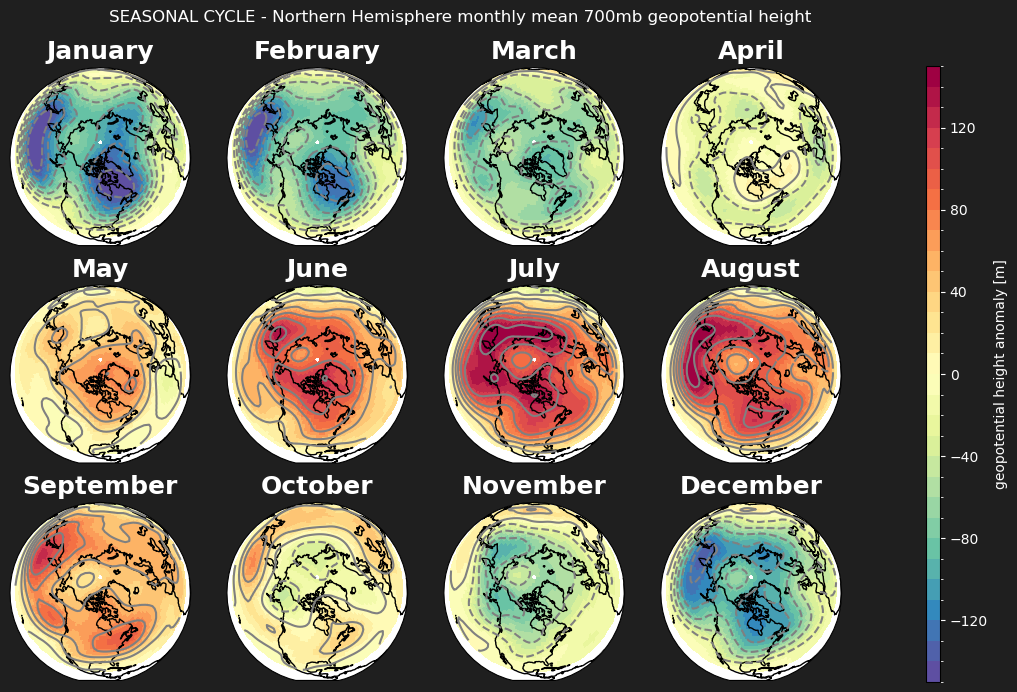

In [44]:
# following the methods of Liang et al. 2017 https://doi.org/10.1175/JCLI-D-17-0149.1

import xarray as xr
from xeofs.xarray import EOF,Rotator # see https://github.com/nicrie/xeofs
import matplotlib.pyplot as plt
import numpy as np
import cartopy.feature as cfeature
import cartopy. crs as ccrs
from calendar import month_name
from helpers import get_TNH_idx
import pandas as pd
import matplotlib as mpl

#
mpl.rcParams['text.color'] = 'white'
mpl.rcParams['axes.labelcolor'] = 'white'
mpl.rcParams['xtick.color'] = 'white'
mpl.rcParams['ytick.color'] = 'white'
#

# load test dataset and plot overview (standard deviation)
ds  = xr.open_dataset('data/NCEP_reanalysis/hgt.mon.mean.nc')
hgt = ds.hgt.sel(level=700.,lat=slice(90,20))

# linearry detrend the data:
coeffs    = hgt.polyfit(dim='time',deg=1).polyfit_coefficients
linfit    = xr.polyval(hgt.time,coeffs=coeffs)
hgt      -= linfit

# compute and remove climatology:
hgt_climatology = hgt.sel(time=slice('1981','2010')).groupby('time.month').mean()
hgt_a = hgt.groupby('time.month') - hgt_climatology

# Plot climatology
fig = plt.figure(figsize=(12,8),facecolor='#1f1f1f')
gs = fig.add_gridspec(1,2,width_ratios=[60,1],hspace=0)
gs0 = gs[0].subgridspec(3,4)
#fig,axes = plt.subplots(3,4,figsize=(12,9),subplot_kw={'projection':ccrs.Orthographic(central_latitude=80,central_longitude=-90)},facecolor='#1f1f1f')
for month,grid in zip(hgt_climatology,gs0):
    ax = fig.add_subplot(grid,projection=ccrs.Orthographic(central_latitude=80,central_longitude=-90))
    im = month.plot(ax=ax,transform=ccrs.PlateCarree(),add_colorbar=False,cmap='Spectral_r',levels=np.arange(-150,160,10))
    month.plot.contour(ax=ax,transform=ccrs.PlateCarree(),colors='grey',levels=np.arange(-150,175,25))
    ax.set_title(month_name[int(month.month.values)],fontsize=18,weight='bold')
    ax.add_feature(cfeature.COASTLINE,zorder=1)

cax = fig.add_subplot(gs[1])
cb = fig.colorbar(im,cax=cax,label='geopotential height anomaly [m]')

fig.savefig('figures/seasonal_cycle_700mb_hgt.png',bbox_inches='tight',pad_inches=.1,facecolor='#3b3838')
fig.suptitle('SEASONAL CYCLE - Northern Hemisphere monthly mean 700mb geopotential height',y=.95)

TNH = get_TNH_idx(dropna=True)


Apply **EOF ANALYSIS**

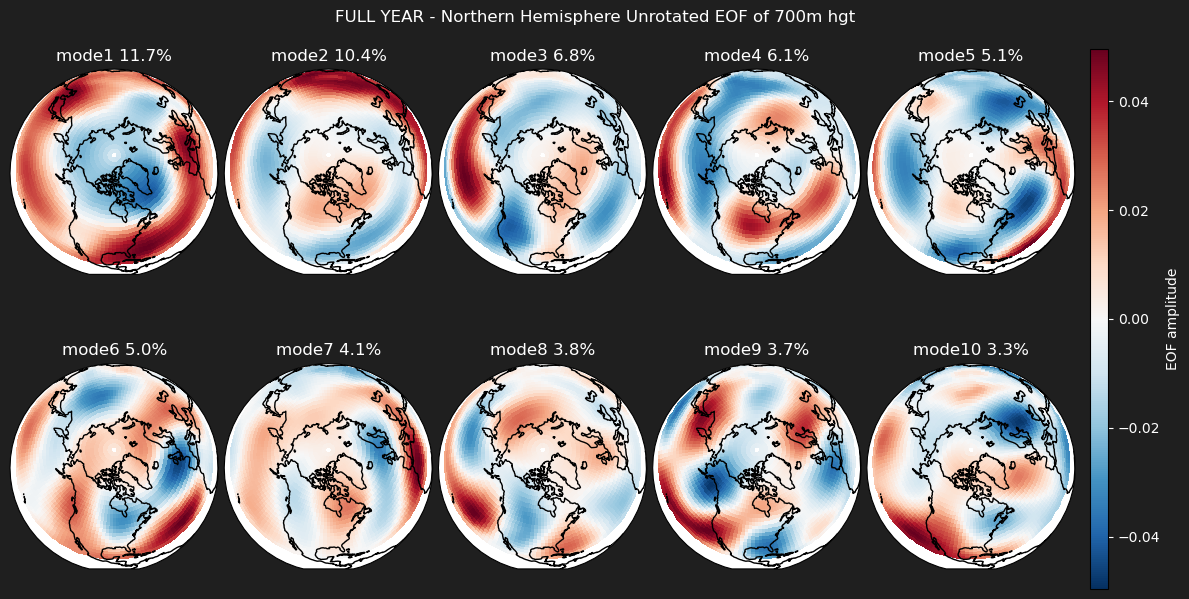

In [26]:
model = EOF(hgt_a,
            n_modes=10,
            norm=True, # computing correlations instead of covariances
            dim=['time'],
            weights='coslat')
model.solve()
expvars = model.explained_variance_ratio()
eofs = model.eofs().transpose('mode','lat','lon')
pcs = model.pcs().transpose('mode','time')

fig_eof = plt.figure(figsize=(12,6),facecolor='#1f1f1f')
gs = fig_eof.add_gridspec(1,2,width_ratios=[60,1])
gs0 = gs[0].subgridspec(2,5)
for eof,pc,expvar,grid in zip(eofs,pcs,expvars,gs0):
    ax = fig_eof.add_subplot(grid,projection=ccrs.Orthographic(central_latitude=80,central_longitude=-90))
    im_eof = eof.plot(ax=ax,add_colorbar=False,transform=ccrs.PlateCarree())
    ax.set_title(f'mode{eof.mode.values} {np.round(expvar.values*100,1)}%')
    ax.add_feature(cfeature.COASTLINE,zorder=1)

cax = fig_eof.add_subplot(gs[1])
cb = fig.colorbar(im_eof,cax=cax,label='EOF amplitude')

fig_eof.suptitle('FULL YEAR - Northern Hemisphere Unrotated EOF of 700m hgt',y=.99)
plt.tight_layout()
plt.show()
fig_eof.savefig('figures/eof_raw.png',bbox_inches='tight',pad_inches=.1,facecolor='#3b3838')

Now, apply **ROTATION**

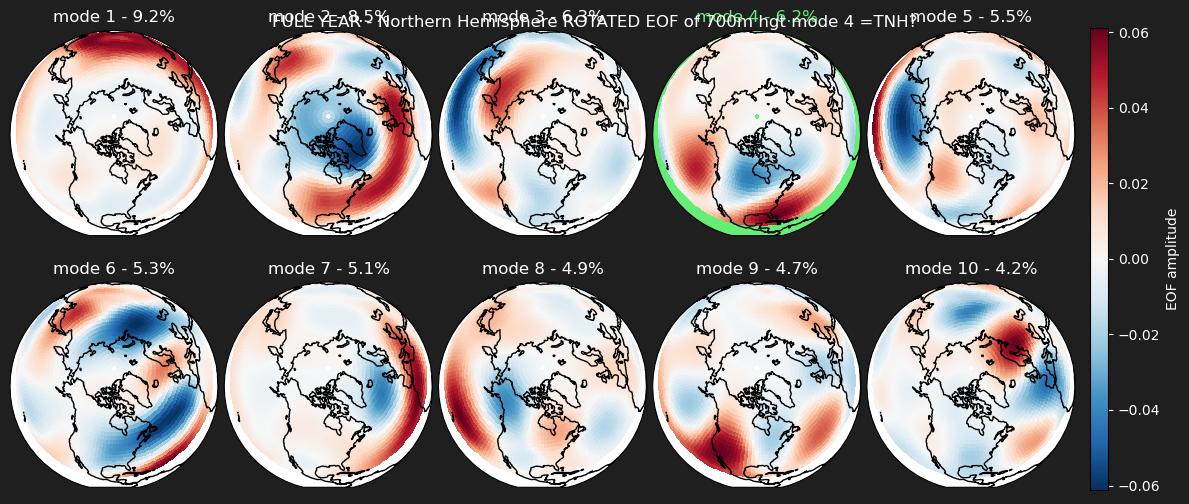

In [43]:
model_rot = Rotator(model,n_rot=10,power=1) # power=1 means orthogonal varimax rotation
expvar_rot = model_rot.explained_variance_ratio()
eofs_rot = model_rot.eofs().transpose('mode','lat','lon')
pcs_rot = model_rot.pcs().transpose('mode','time')
# check for correlation with TNH idx from NOAA
pcs_rot = pcs_rot.assign_coords(corr_TNH=xr.corr(TNH,pcs_rot,dim='time').round(2)*100)
mode_max_corr = pcs_rot.corr_TNH.idxmax().values

fig_reof = plt.figure(figsize=(12,5.0),facecolor='#1f1f1f')
gs = fig_reof.add_gridspec(1,2,width_ratios=[60,1])
gs0 = gs[0].subgridspec(2,5)
for eof,pc,expvar,grid in zip(eofs_rot,pcs_rot,expvar_rot,gs0):
    ax = fig_reof.add_subplot(grid,projection=ccrs.Orthographic(central_latitude=80,central_longitude=-90))
    im_reof = eof.plot(ax=ax,add_colorbar=False,transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE,zorder=1)
    if eof.mode.values == mode_max_corr:
        # then, this mode seems to be the physical TNH mode
        ax.set_facecolor('#65ed76') 
        fontcolor = '#65ed76'
        # save the pc timeseries (normalized by its std.dev.)
        full_year_pc = pc/pc.std()
    else:
        fontcolor = 'white'
    ax.set_title(f'mode {eof.mode.values} - {np.round(expvar.values*100,1)}%',color=fontcolor)
    #ax.set_title(f'mode{eof.mode.values} {np.round(expvar.values*100,1)}%expvar\ncorr TNH={int(pc.corr_TNH)}%',color=fontcolor)
cax = fig_reof.add_subplot(gs[1])
cb = fig.colorbar(im_reof,cax=cax,label='EOF amplitude')

plt.tight_layout()
fig_reof.savefig('figures/rotated_eof_full_year.png',bbox_inches='tight',pad_inches=.1,facecolor='#3b3838')
fig_reof.suptitle(f'FULL YEAR - Northern Hemisphere ROTATED EOF of 700m hgt mode {int(pcs_rot.corr_TNH.idxmax().values)} =TNH?',y=.99)
plt.show()

Now, months seperately

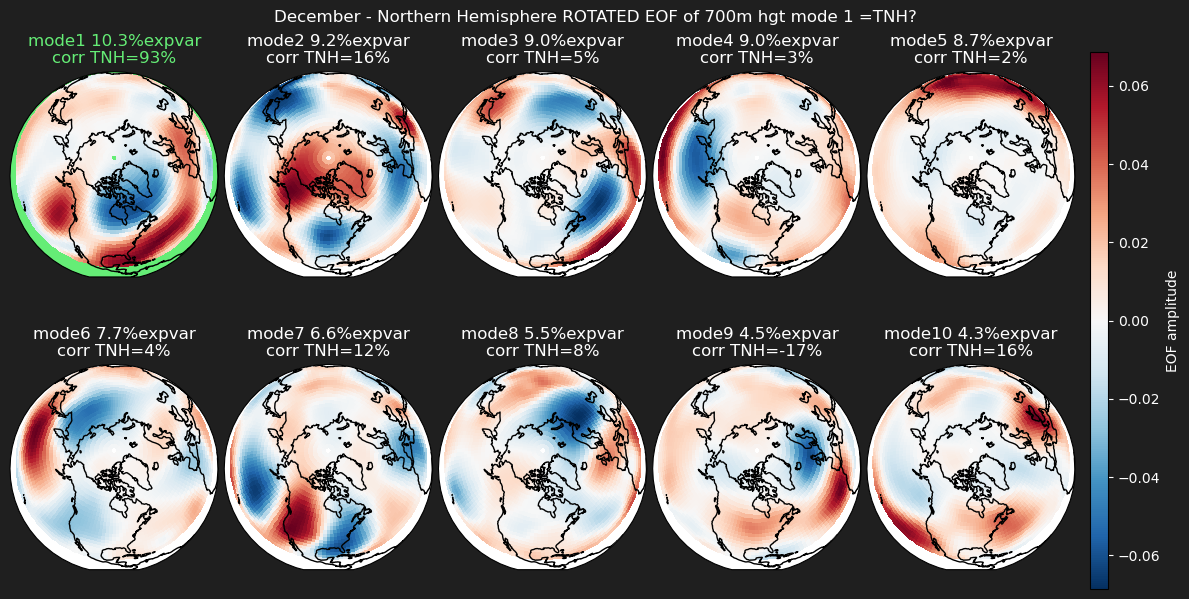

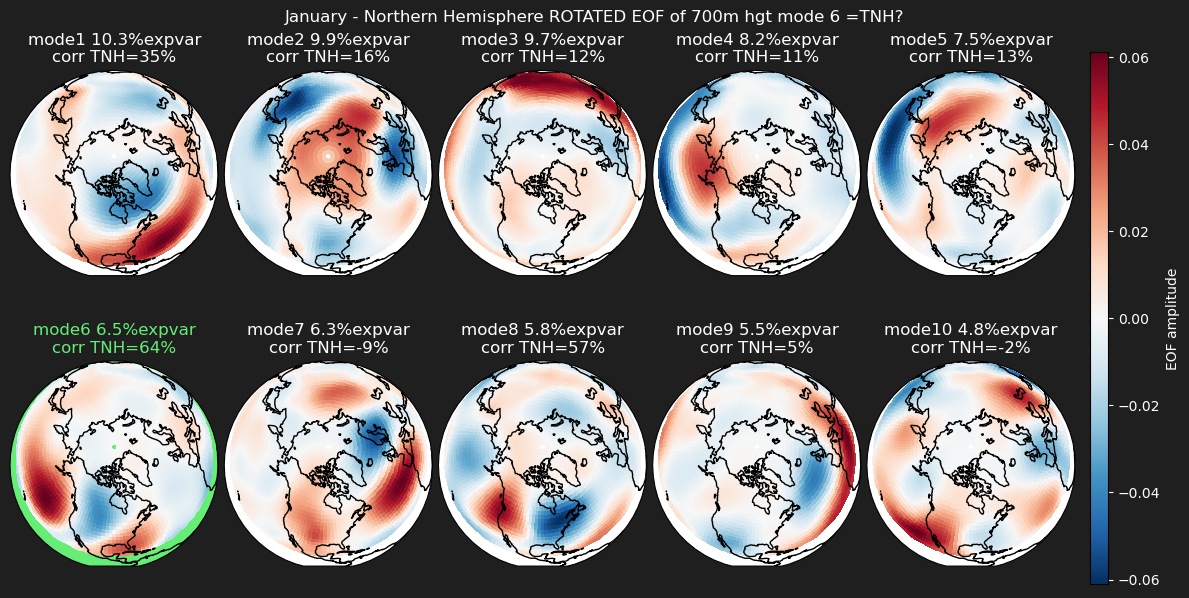

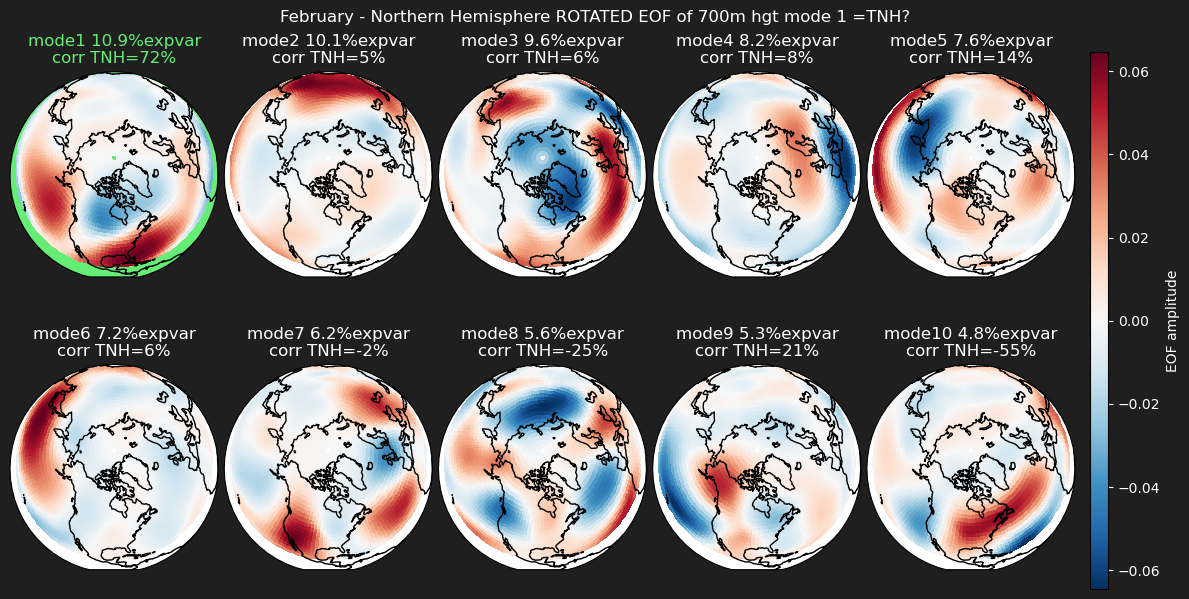

In [29]:
idx_PCs = []
for month in [12,1,2]:
    hgt_month = hgt_a.loc[{'time':hgt_a.time.dt.month==month}]
    month_str = month_name[month]
    model_ = EOF(hgt_month,
                n_modes=10,
                norm=True, # computing correlations instead of covariances
                dim=['time'],
                weights='coslat')
    model_.solve()
    # Apply rotation:
    model_rot_ = Rotator(model_,n_rot=10,power=1) # power=1 means orthogonal varimax rotation
    expvar_rot_ = model_rot_.explained_variance_ratio()
    eofs_rot_ = model_rot_.eofs().transpose('mode','lat','lon')
    pcs_rot_ = model_rot_.pcs().transpose('mode','time')
    # check for correlation with TNH idx from NOAA
    pcs_rot_ = pcs_rot_.assign_coords(corr_TNH=xr.corr(TNH,pcs_rot_,dim='time').round(2)*100)
    
    fig_reof = plt.figure(figsize=(12,6),facecolor='#1f1f1f')
    mode_max_corr = pcs_rot_.corr_TNH.idxmax().values
    gs = fig_reof.add_gridspec(1,2,width_ratios=[60,1])
    gs0 = gs[0].subgridspec(2,5)
    for eof,pc,expvar,grid in zip(eofs_rot_,pcs_rot_,expvar_rot_,gs0):
        ax = fig_reof.add_subplot(grid,projection=ccrs.Orthographic(central_latitude=80,central_longitude=-90))
        im_reof = eof.plot(ax=ax,add_colorbar=False,transform=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE,zorder=1)
        if eof.mode.values == mode_max_corr:
            # then, this mode seems to be the physical TNH mode
            ax.set_facecolor('#65ed76') 
            fontcolor = '#65ed76'
            # save the pc timeseries (normalized by its std.dev.)
            idx_PCs.append(pc/pc.std())
        else:
            fontcolor = 'white'
        ax.set_title(f'mode{eof.mode.values} {np.round(expvar.values*100,1)}%expvar\ncorr TNH={int(pc.corr_TNH)}%',color=fontcolor)

    cax = fig_reof.add_subplot(gs[1])
    cb = fig.colorbar(im_reof,cax=cax,label='EOF amplitude')

    fig_reof.suptitle(f'{month_str} - Northern Hemisphere ROTATED EOF of 700m hgt mode {int(pcs_rot_.corr_TNH.idxmax().values)} =TNH?',y=.99)
    plt.tight_layout()
    plt.show()
    fig_reof.savefig(f'figures/rotated_eof_{month_str}.png',bbox_inches='tight',pad_inches=.1,facecolor='#3b3838')


1950-01-01T00:00:00.000000000 1959-12-01T00:00:00.000000000
1960-01-01T00:00:00.000000000 1969-12-01T00:00:00.000000000
1970-01-01T00:00:00.000000000 1979-12-01T00:00:00.000000000
1980-01-01T00:00:00.000000000 1989-12-01T00:00:00.000000000
1990-01-01T00:00:00.000000000 1999-12-01T00:00:00.000000000
2000-01-01T00:00:00.000000000 2009-12-01T00:00:00.000000000
2010-01-01T00:00:00.000000000 2019-12-01T00:00:00.000000000
2020-01-01T00:00:00.000000000 2023-02-01T00:00:00.000000000


Text(0.5, 1.02, 'each year contains January, February, December')

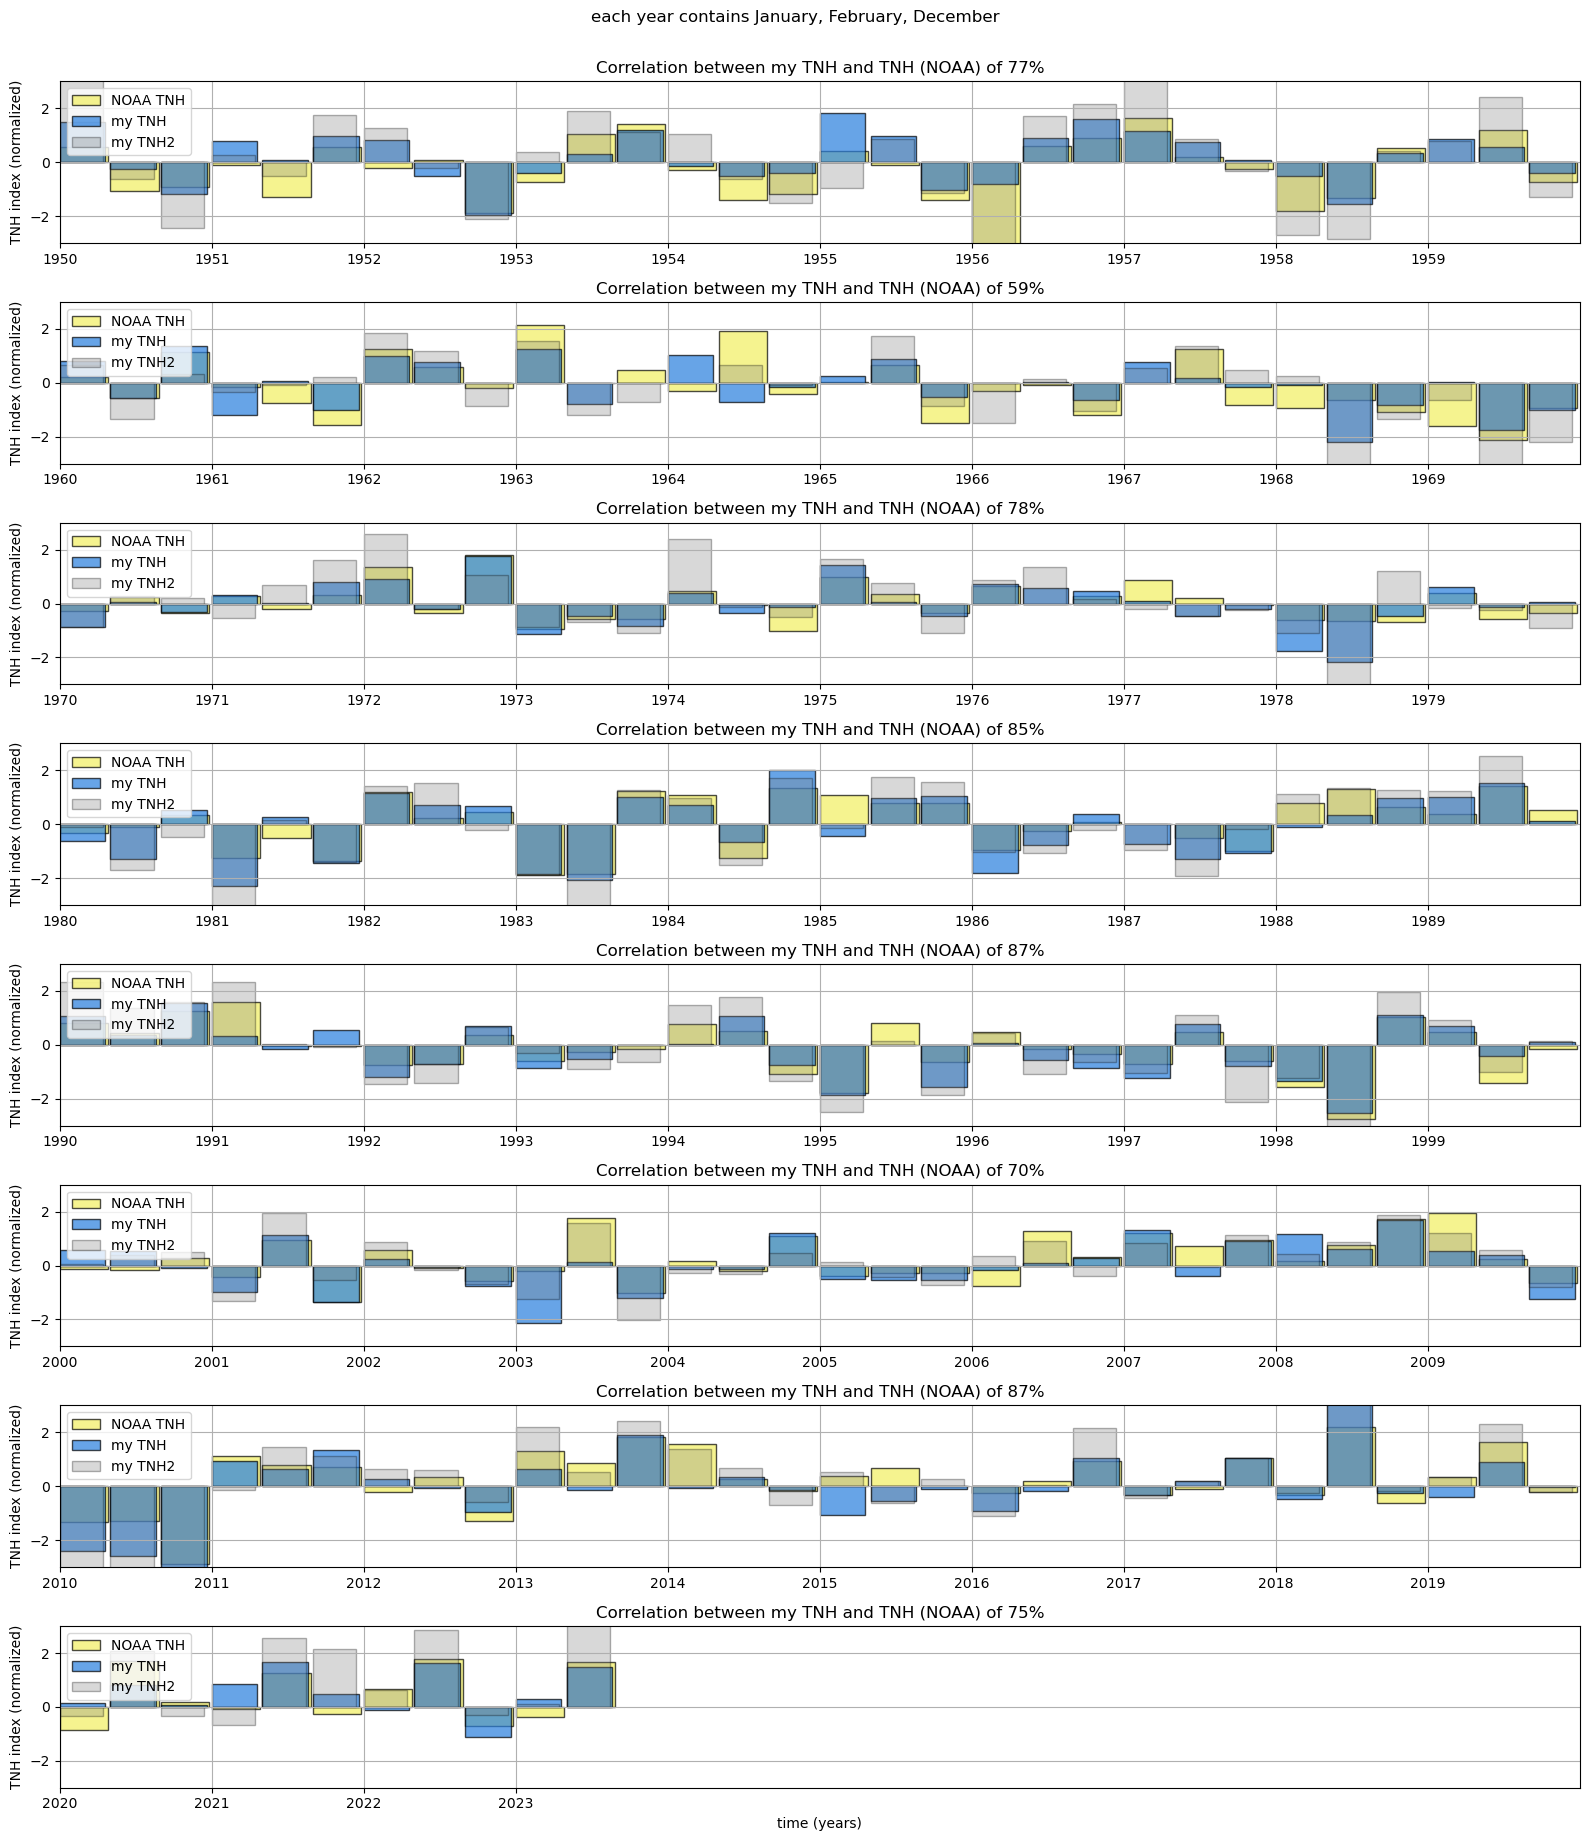

In [228]:
my_TNH = xr.concat(idx_PCs,dim='time').sortby('time')
my_TNH = my_TNH.loc[my_TNH.time.dt.month.isin([12,1,2])]
my_TNH2 = full_year_pc.loc[full_year_pc.time.dt.month.isin([12,1,2])]

fig,axes = plt.subplots(8,1,figsize=(16,18))

dt = 10 #years 
for ax,year in zip(axes,np.arange(1950,2023,dt)):
    start_year = str(year)
    stop_year  = str(year+dt-1)

    TNH_ = TNH.sel(time=slice(start_year,stop_year))
    print(TNH_.time.min().values,TNH_.time.max().values)
    my_TNH_ = my_TNH.sel(time=slice(start_year,stop_year))
    my_TNH2_ = my_TNH2.sel(time=slice(start_year,stop_year))
    if not my_TNH_.time.isin(TNH_.time).all():
        raise UserWarning('ATTENTION')


    corr = int(np.round(xr.corr(TNH_,my_TNH_).values,2)*100)
    ax.bar(np.arange(TNH_.size),TNH_.values,width=.95,label='NOAA TNH',alpha=.7,align='edge',color='#f2ef60',edgecolor='black')
    ax.bar(np.arange(my_TNH_.size),my_TNH_.values,width=.90,label='my TNH',alpha=.7,align='edge',color='#277ede',edgecolor='black')
    ax.bar(np.arange(my_TNH2_.size),my_TNH2_.values,width=.85,label='my TNH2',alpha=.3,align='edge',color='grey',edgecolor='black')

    ticks_int = np.arange(0,TNH_.time.size,3)
    ax.set_xticks(ticks_int)
    tickyears = TNH_.time[ticks_int].dt.year.values
    ax.set_xticklabels(tickyears)
    #my_TNH.plot.bar(label='my TNH index')
    #TNH.plot.bar(label='NOAA TNH index')
    ax.legend(loc='upper left')
    ax.set_title(f'Correlation between my TNH and TNH (NOAA) of {corr}%')
    ax.grid()
    ax.set_xlim(0,30)
    ax.set_ylim(-3,3)
    ax.set_ylabel('TNH index (normalized)')
ax.set_xlabel('time (years)')
plt.tight_layout()
fig.suptitle('each year contains January, February, December',y=1.02)

In [177]:
tickyears.dt.year

<xarray.DataArray 'year' (time: 11)>
array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020],
      dtype=int64)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01 2011-01-01 ... 2020-01-01